<h1>IBM Datascience Capstone Project - Risk Factors for Severe Car Accidents</h1>


<h3>Introduction</h3>

While travelling on the road constantly gets safer with advances in car safety systems, road accidents are still commonplace and will be for the foreseeable future. Policymakers do have a set of tools at hand to reduce the human costs, from expensive measures like stricter car safety regulations or improving the road infrastructure to low cost measures like reduced speed limits. While the latter are cheap to implement, they are equally annoying to motorists. It is therefore important to use sparingly to increase the acceptance and adherence of the drivers. To guide such a targeted approach it is nessary to know under which conditions serious or fatal accidents are most likely to happen. This is what I seek to investigate in this project.

<h3>Data</h3>

The open dataset of personal road injury accidents in 2019 I am using is published by the UK Department for Transportation and can be accessed under *https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data*. It includes all personal injury accidents on public roads in the UK reported and recodered using the STATS19 accident reporting form in 2019. A variable lookup guide can be accessed under *http://data.dft.gov.uk/road-accidents-safety-data/variable%20lookup.xls*. Variables contained are:

Accident Index,
Police Force,
Accident Severity,
Number of Vehicles,
Number of Casualties,
Date (DD/MM/YYYY),
Day of Week,
Time (HH:MM),
Location Easting OSGR (Null if not known),
Location Northing OSGR (Null if not known),
Longitude (Null if not known),
Latitude (Null if not known),
Local Authority (District),
Local Authority (Highway Authority - ONS code),
1st Road Class,
1st Road Number,
Road Type,
Speed limit,
Junction Detail,
Junction Control,
2nd Road Class,
2nd Road Number,
Pedestrian Crossing-Human Control,
Pedestrian Crossing-Physical Facilities,
Light Conditions,
Weather Conditions,
Road Surface Conditions,
Special Conditions at Site,
Carriageway Hazards,
Urban or Rural Area,
Did Police Officer Attend Scene of Accident,
Lower Super Ouput Area of Accident_Location (England & Wales only)

The target variable will be Accident Severety with the categories being 1=Fatal, 2=Serious and 3=Slight. Some variables e.g. Police Force getting involved, Number of Casualties cannot be used for predicting the outcome of accidents because they are only determined after the accident and depend instead on the severity of the accident. Others like Date or Longitude and Latidude seem rather useless for prediction. The most promissing are the ones describing the conditions at the site of the accidents, like weather and road conditions.

<h3>Methodology</h3>
The target variable in the data set can take three values: fatal, serious and slight. Since the difference between serious and fatal accidents is mostly in the outcome and not the accident itself I am grouping those together to make the analysis simpler. I further bin the time of the day into four bins with broadly similar conditions, nightttime from midnight to 6am, 6am to noon, noon to 6 pm and 6pm to midnight.
To get a general idea under what circumstances accidents happen, we can look at the frequencies dependent on the different explanatory variables.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
!wget -O DfTRoadSafety_Accidents_2019.zip http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2019.zip

--2020-10-09 09:12:11--  http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2019.zip
Resolving data.dft.gov.uk (data.dft.gov.uk)... 52.218.61.250
Connecting to data.dft.gov.uk (data.dft.gov.uk)|52.218.61.250|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4253666 (4.1M) [application/x-zip-compressed]
Saving to: ‘DfTRoadSafety_Accidents_2019.zip’

100%[======================================>] 4,253,666   16.5MB/s   in 0.2s   

2020-10-09 09:12:15 (16.5 MB/s) - ‘DfTRoadSafety_Accidents_2019.zip’ saved [4253666/4253666]



In [3]:
from zipfile import ZipFile
with ZipFile('DfTRoadSafety_Accidents_2019.zip', 'r') as zipObj:
   zipObj.extractall()

In [47]:
df= pd.read_csv("Road Safety Data - Accidents 2019.csv", na_values=-1)
df['Weekend']=df['Day_of_Week'].apply(lambda x: 1 if x in [1,7] else 0) #make a new weekend variable
df=df[['Accident_Severity','Weekend','Time','Road_Type','Speed_limit','Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Special_Conditions_at_Site']] #select relevant variables
df['Road_Type'].replace(9, np.nan, inplace = True) #replace the numbers representing NANs with actual NANs
df['Weather_Conditions'].replace(9, np.nan, inplace = True)
df['Light_Conditions'].replace(7, np.nan, inplace = True)
df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(117536, 9)

In [48]:
df.dropna(axis=0, inplace=True) #drop rows with NANs
df['Time'] = df['Time'].map(lambda x: x.replace(':','')) #make time bins
df=df.astype(int)
bins = np.linspace(0, 2400, 5)
df['Time'] = pd.cut(df['Time'], bins, include_lowest=True )
df['Accident_Severity']=df['Accident_Severity'].mask(df['Accident_Severity']==2,1) #group fatal and serious accidents together
df=df.astype('category') #change the data type since all variables are categorical
df['Accident_Severity']=df['Accident_Severity'].cat.rename_categories({1: 'Serious/Fatal', 3: 'Slight'}) #replace the category numbers with the actual names
df['Weekend']=df['Weekend'].cat.rename_categories({1: 'Weekend', 0: 'Weekday'})
df['Road_Type']=df['Road_Type'].cat.rename_categories({1: 'Roundabout',2:'One way street', 3: 'Dual carriageway', 6:'Single carriageway',7:'Slip road',12:'One way street/Slip road'})
df['Light_Conditions']=df['Light_Conditions'].cat.rename_categories({1: 'Daylight',4:'Darkness - lights lit', 5: 'Darkness - lights unlit', 6:'Darkness - no lighting',7:'Darkness - lighting unknown'})
df['Weather_Conditions']=df['Weather_Conditions'].cat.rename_categories({1: 'Fine no high winds',2:'Raining no high winds', 3: 'Snowing no high winds', 4:'Fine + high winds',5:'Raining + high winds',6:'Snowing + high winds',7:'Fog or mist',8:'Other'})
df['Road_Surface_Conditions']=df['Road_Surface_Conditions'].cat.rename_categories({1: 'Dry',2:'Wet or damp', 3: 'Snow', 4:'Frost or ice',5:'Flood over 3cm. deep',6:'Oil or Diesel',7:'Mud'})
df['Special_Conditions_at_Site']=df['Special_Conditions_at_Site'].cat.rename_categories({0:'None', 1: 'Auto traffic signal - out',2:'Auto signal part defective', 3: 'Road sign or marking defective or obscured', 4:'Roadworks',5:'Road surface defective',6:'Oil or diesel',7:'Mud'})
df.shape

(109346, 9)

In [49]:
df.head()

,Accident_Severity,Weekend,Time,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site
62187,Slight,Weekday,"(1800.0, 2400.0]",Single carriageway,30,Daylight,Fine no high winds,Dry,None
69518,Slight,Weekday,"(1200.0, 1800.0]",Single carriageway,40,Darkness - no lighting,Fine no high winds,Wet or damp,None
79233,Slight,Weekday,"(1200.0, 1800.0]",Single carriageway,40,Darkness - lights lit,Fine no high winds,Wet or damp,None
55155,Slight,Weekday,"(1200.0, 1800.0]",Single carriageway,30,Daylight,Fine no high winds,Dry,None
24336,Slight,Weekend,"(-0.001, 600.0]",Single carriageway,30,Darkness - lights lit,Other,Wet or damp,None


Text(0, 0.5, 'Frequency')

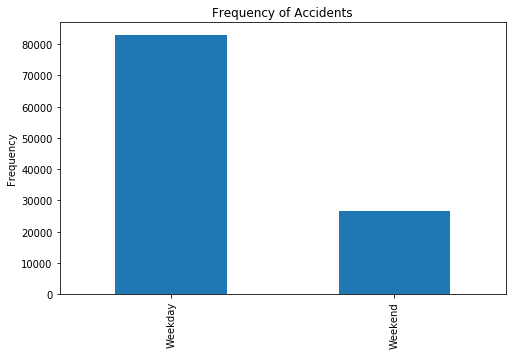

In [50]:
df['Weekend'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

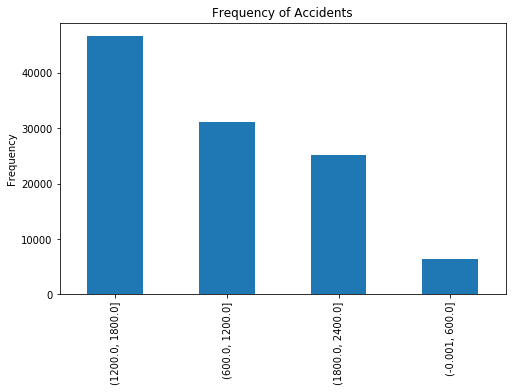

In [51]:
df['Time'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Time Window")

Text(0, 0.5, 'Frequency')

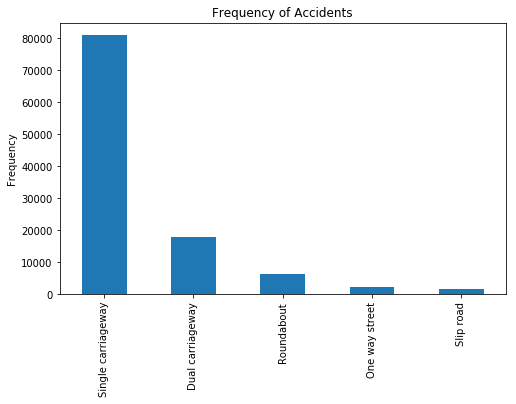

In [52]:
df['Road_Type'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Road Type")

Text(0, 0.5, 'Frequency')

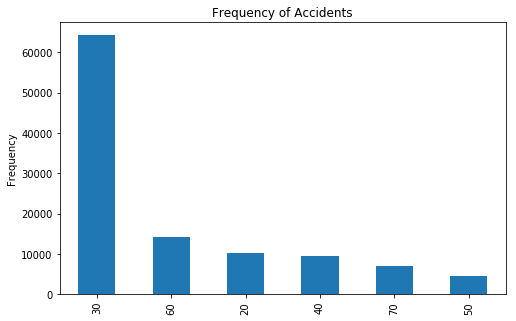

In [53]:
df['Speed_limit'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Speed Limit (mph)")

Text(0, 0.5, 'Frequency')

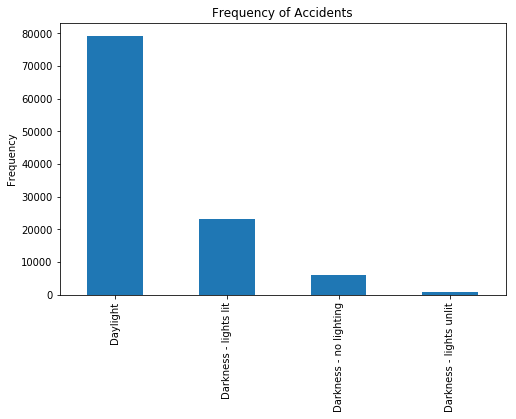

In [54]:
df['Light_Conditions'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Light Conditions")

Text(0, 0.5, 'Frequency')

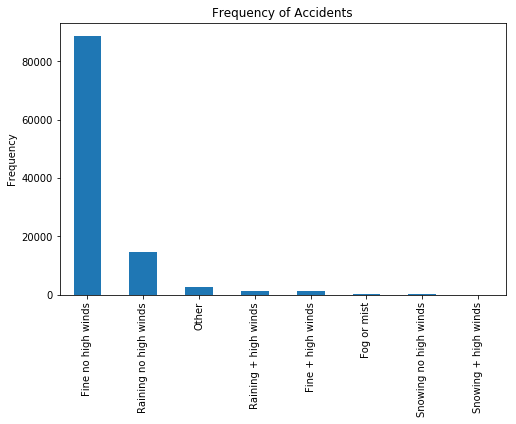

In [55]:
df['Weather_Conditions'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Weather Conditions")

Text(0, 0.5, 'Frequency')

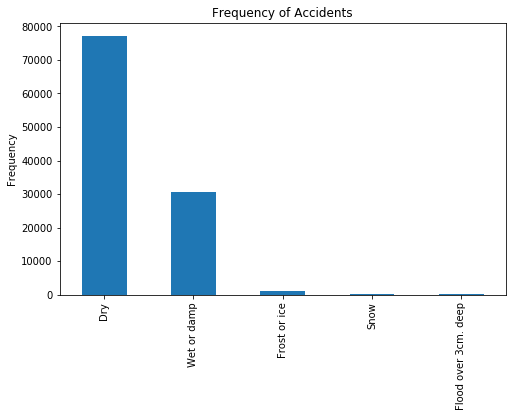

In [56]:
df['Road_Surface_Conditions'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Road Surface Conditions")

Text(0, 0.5, 'Frequency')

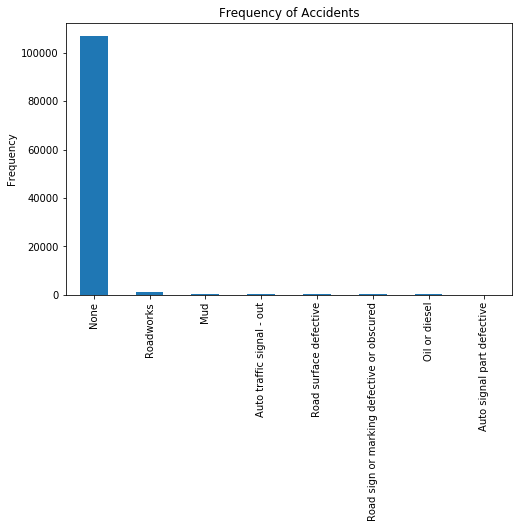

In [57]:
df['Special_Conditions_at_Site'].value_counts().plot(kind='bar', figsize=(8, 5),title="Frequency of Accidents")
plt.ylabel("Frequency")
plt.xlabel("Special Conditions")

Somewhat surprising we see that most accidents happen under generally good conditions, in daytime, places with a low speed limit and under dry coonditions. This doesn't tell us too much though since those are the probably the conditions under which most of the traffic takes places.
Next we will look at the individual conditions again to see if there is differences in the ratio of serious to slight accidents.

In [58]:
pd.crosstab(df.Weekend, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Weekend,,
Weekday,0.212145,0.787855
Weekend,0.243968,0.756032


In [59]:
pd.crosstab(df.Time, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Time,,
"(-0.001, 600.0]",0.293017,0.706983
"(600.0, 1200.0]",0.201207,0.798793
"(1200.0, 1800.0]",0.211939,0.788061
"(1800.0, 2400.0]",0.239188,0.760812


In [60]:
pd.crosstab(df.Road_Type, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Road_Type,,
Roundabout,0.149147,0.850853
One way street,0.165348,0.834652
Dual carriageway,0.202733,0.797267
Single carriageway,0.232074,0.767926
Slip road,0.166010,0.833990


In [61]:
pd.crosstab(df.Speed_limit, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Speed_limit,,
20,0.174051,0.825949
30,0.200773,0.799227
40,0.233716,0.766284
50,0.239929,0.760071
60,0.322590,0.677410
70,0.222786,0.777214


In [62]:
pd.crosstab(df.Light_Conditions, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Light_Conditions,,
Daylight,0.208854,0.791146
Darkness - lights lit,0.229670,0.770330
Darkness - lights unlit,0.245573,0.754427
Darkness - no lighting,0.324048,0.675952


In [63]:
pd.crosstab(df.Weather_Conditions, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Weather_Conditions,,
Fine no high winds,0.221811,0.778189
Raining no high winds,0.211177,0.788823
Snowing no high winds,0.189189,0.810811
Fine + high winds,0.256108,0.743892
Raining + high winds,0.255132,0.744868
Snowing + high winds,0.176471,0.823529
Fog or mist,0.256065,0.743935
Other,0.167658,0.832342


In [64]:
pd.crosstab(df.Road_Surface_Conditions, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Road_Surface_Conditions,,
Dry,0.216988,0.783012
Wet or damp,0.227240,0.772760
Snow,0.172996,0.827004
Frost or ice,0.222812,0.777188
Flood over 3cm. deep,0.233129,0.766871


In [65]:
pd.crosstab(df.Special_Conditions_at_Site, df.Accident_Severity).apply(lambda r: r/r.sum(), axis=1)

Accident_Severity,Serious/Fatal,Slight
Special_Conditions_at_Site,,
None,0.220167,0.779833
Auto traffic signal - out,0.181467,0.818533
Auto signal part defective,0.216216,0.783784
Road sign or marking defective or obscured,0.163158,0.836842
Roadworks,0.178147,0.821853
Road surface defective,0.340611,0.659389
Oil or diesel,0.290503,0.709497
Mud,0.218310,0.781690


Here the results look quite expected. We see a higher percentage of severe accidents when there is surface defects or oil spills, flooding, frost or wetness, fog or wind and generally conditions that allow faster driving, like high speed limits, weekends or nighttime.
Next we try to predict the severity based on the conditions. Since there is a lot more slight than heavy accidents in the dataset, we will balance this first by randomly selecting 10000 accidents from each group to train and test the models on. Targeting a categorical variable we will try the methods introduced in the module for this: k-Nearest Neighbors, Decision Trees, Support Vector Machines and Logistic Regression.

In [66]:
# create a random balanced sample of the data
df_slight=df[df['Accident_Severity']=='Slight'].sample(n=10000, random_state=1)
df_severe=df[df['Accident_Severity']=='Serious/Fatal'].sample(n=10000, random_state=1)
df=df_slight.append(df_severe)

In [67]:
# make dummies from the categorical variables and standardize
X = pd.get_dummies(df[['Weekend','Time','Speed_limit','Light_Conditions','Weather_Conditions','Road_Type','Road_Surface_Conditions','Special_Conditions_at_Site']], drop_first=True) 
y = df['Accident_Severity'].values.astype(str)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [68]:
# split into training and testing data
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
dfTree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
dfTree.fit(X_train,y_train)
predTree = dfTree.predict(X_test)
metrics.accuracy_score(y_test, predTree)

0.571

Support Vector Machine

In [71]:
from sklearn import svm

In [72]:
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [73]:
predsvc = svc.predict(X_test)
metrics.accuracy_score(y_test, predsvc)

0.57275

kNN

In [74]:
from sklearn.neighbors import KNeighborsClassifier

In [75]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.52475, 0.50075, 0.52625, 0.51775, 0.52925, 0.5095 , 0.52   ,
       0.50375, 0.51325])

Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
predLR = LR.predict(X_test)
metrics.accuracy_score(y_test, predLR)

0.567

In [80]:
pred_test_neigh = neigh.predict(X_test)
pred_test_predTree = dfTree.predict(X_test)
pred_test_svc = svc.predict(X_test)
pred_test_LR = LR.predict(X_test)

In [82]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [83]:
j_neigh=jaccard_similarity_score(y_test, pred_test_neigh)
j_predTree=jaccard_similarity_score(y_test, pred_test_predTree)
j_svc=jaccard_similarity_score(y_test, pred_test_svc)
j_LR=jaccard_similarity_score(y_test, pred_test_LR)

In [84]:
f1_neigh=f1_score(y_test, pred_test_neigh, average='weighted')
f1_predTree=f1_score(y_test, pred_test_predTree, average='weighted') 
f1_svc=f1_score(y_test, pred_test_svc, average='weighted') 
f1_LR=f1_score(y_test, pred_test_LR, average='weighted')

In [85]:
pred_test_LR_prob = LR.predict_proba(X_test)
ll_LR=log_loss(y_test, pred_test_LR_prob)

In [86]:
data={'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],'Jaccard':[j_neigh,j_predTree,j_svc,j_LR],'F1-score':[f1_neigh,f1_predTree,f1_svc,f1_LR],'LogLoss':['NA','NA','NA',ll_LR]}
report=pd.DataFrame(data)
report.set_index('Algorithm')

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.51325,0.508698,NA
Decision Tree,0.57100,0.566144,NA
SVM,0.57275,0.568479,NA
Logistic Regression,0.56700,0.566800,0.679015


<h3>Results</h3>
We can see that the Support Vector Machine performs best with an accuracy of 57.28% which is better than random guessing (50%) but not great.

<h3>Discussion</h3>
The accuracy could probably be improved with some more model tuning and a bigger data set for training the model. To determine which factors exactly matter one would have to use other models since in this regard Support Vector Machines are not easily interpretable.

<h3>Conclusion</h3>
We were able to identify factors that probably make traffic accidents more dangerous. We were further able to develop a model predicting this increased danger depending on the conditions. And while the model is not very reliable it could still help traffic control systems or policy makers make decisions.